# **💉INForcast** - Time Series Forcasting using Darts

### Importing Libraries and Package files

In [1]:
import pandas as pd
#from darts import TimeSeries
import seaborn as sns
import matplotlib.pyplot as plt
import os

from inforcast.params import *
from inforcast.main import *

# Hi-resolution Plots and Matplotlib inline
%config InlineBackend.figure_format = 'retina'


# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

In [2]:
import os

directory_path = "../data/"
file_list = os.listdir(directory_path)
file_list

['.DS_Store',
 'Influenza_Predictor_KMC.csv',
 'influenza_predictor2.csv',
 'influenza_predictor.csv',
 'influenzaSMW.csv']

In [3]:
data = pd.read_csv(f'../data/Influenza_Predictor_KMC.csv')

In [4]:
data.head()

,Date of birth,Event date,Event done at ID,Patient ID,Vaccination type,Patient Count
0,02-Dec-1921,05-Oct-2012,E87705,47284219,Influenza Vaccine 1,1
1,02-Dec-1921,15-Sep-2021,E87738,47284219,Fluad Tetra (Seqirus) 1,1
2,16-Aug-1923,27-Sep-2011,E87738,47546740,Influenza Vaccine 1,1
3,16-Aug-1923,29-Sep-2016,E87738,47549110,Inactivated Influenza Vaccine (Split Virion) (...,1
4,17-Feb-1924,17-Oct-2007,E87738,47519726,Influenza Vaccine 1,1


### Loading function from `main.py`
To speed up processing.

In [5]:
data = process_dataframe(data)
data = update_location(data)

In [6]:
data.head()

,dob,date,location,pt_id,vaccine,pt_count,age_at_vaccine
0,1921-12-02,2012-10-05,Elsewhere,47284219,Influenza Vaccine 1,1,91
1,1921-12-02,2021-09-15,E87738,47284219,Fluad Tetra (Seqirus) 1,1,100
2,1923-08-16,2011-09-27,E87738,47546740,Influenza Vaccine 1,1,88
3,1923-08-16,2016-09-29,E87738,47549110,Inactivated Influenza Vaccine (Split Virion) (...,1,93
4,1924-02-17,2007-10-17,E87738,47519726,Influenza Vaccine 1,1,83


### Transform `data` into TimeSeries

In [7]:
df_list = age_groups(data)

2024-01-10 09:49:27.388 
  command:

    streamlit run /Users/janduplessis/.pyenv/versions/3.10.6/envs/inforcast/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


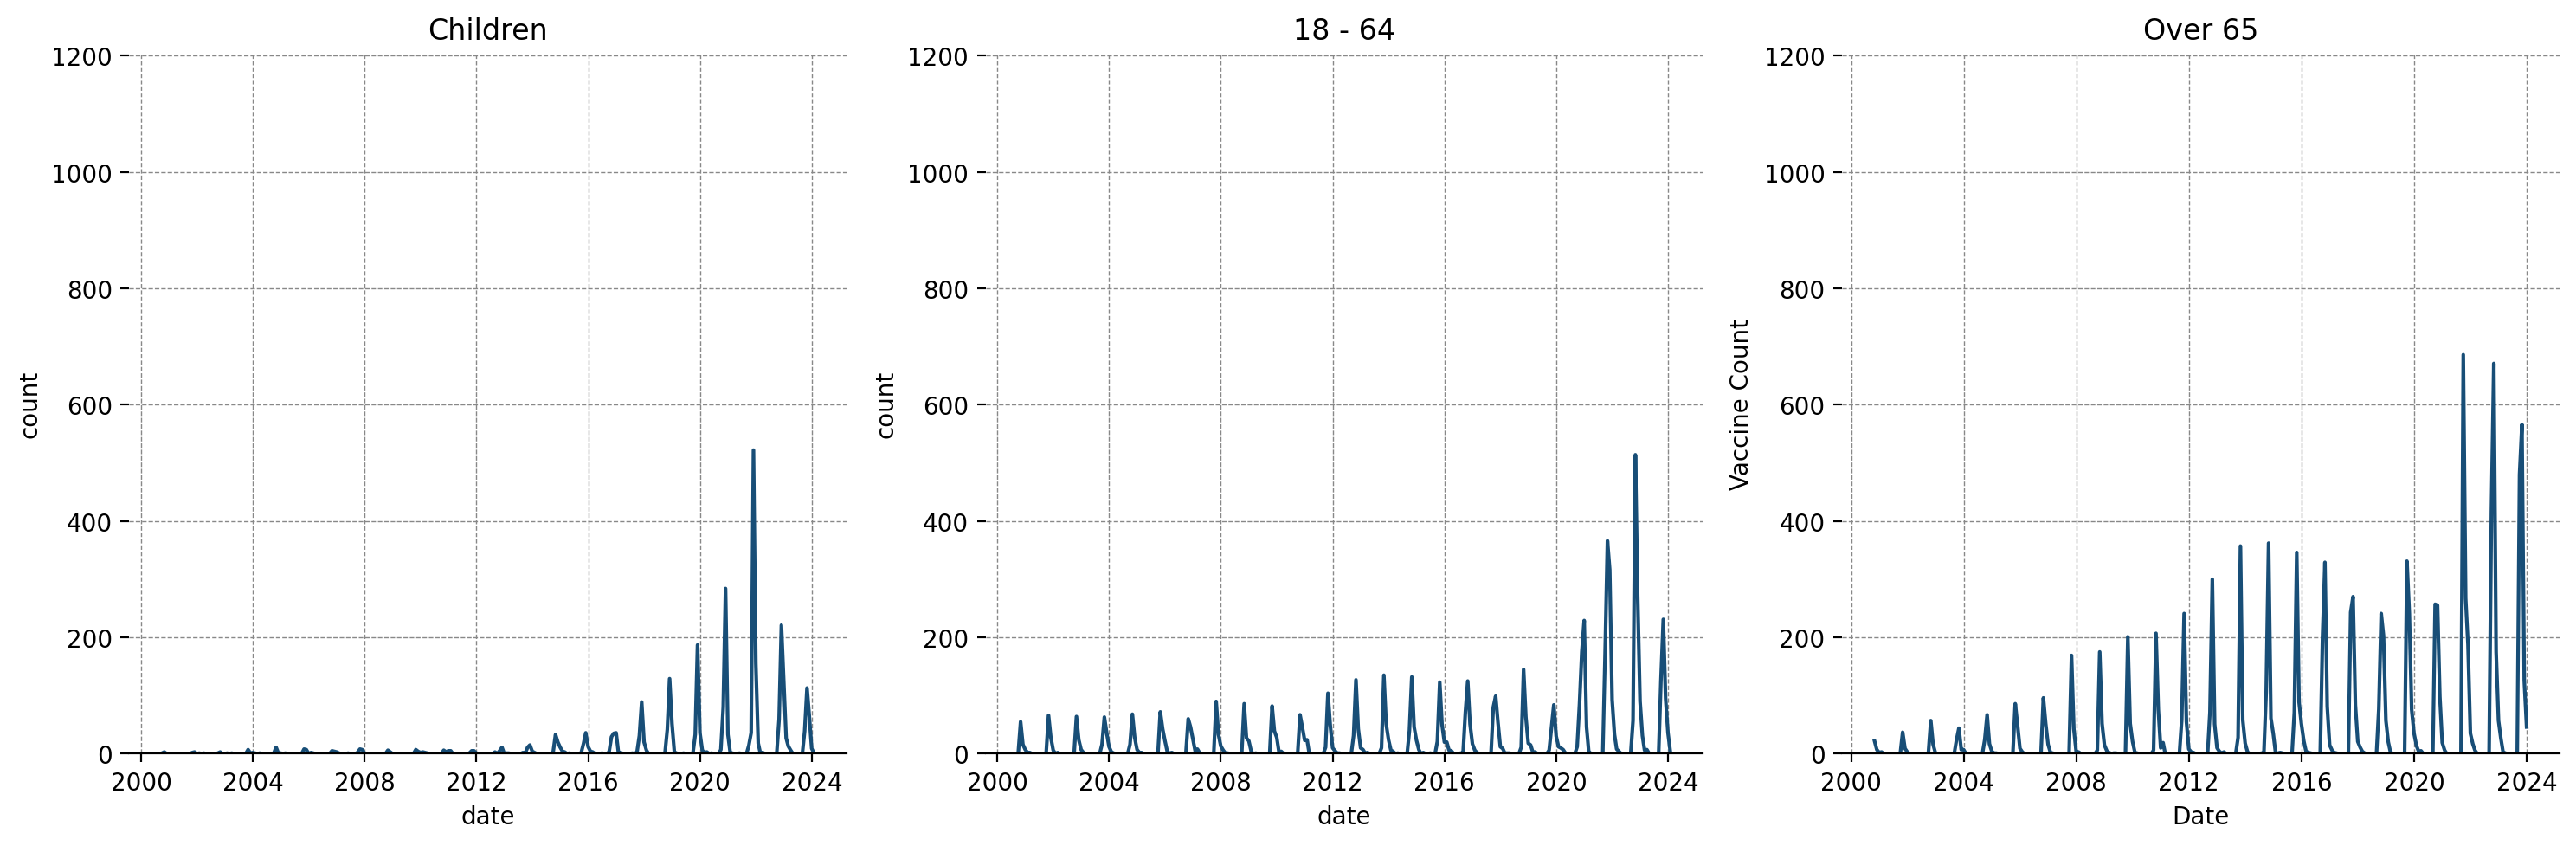

In [8]:
plot_age_groups(df_list, df_list[-1]["count"].max())

# **Darts** TimeSeries Package

### Libraries and initiating TimeSeries Object

In [9]:
from darts import TimeSeries
from darts.datasets import AirPassengersDataset

In [10]:
series =  TimeSeries.from_dataframe(df_list[-1], time_col='date', value_cols='count')

**Diff Plot**

In [11]:
series.diff().plot()

<Axes: xlabel='date'>

In [12]:
train, val = series.split_after(0.80)
train.plot(label="training")
val.plot(label="validation")

<Axes: xlabel='date'>

In [13]:
from darts.utils.statistics import plot_acf, check_seasonality
plot_acf(train, m=12, alpha=0.05)

In [14]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 12.


In [15]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(60)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

<Axes: xlabel='date'>

In [16]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(60)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

<Axes: xlabel='date'>

In [17]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(60)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

<Axes: xlabel='date'>

In [18]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

ValueError: The actual series must be strictly positive to compute the MAPE.


ValueError: The actual series must be strictly positive to compute the MAPE.

In [ ]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

In [ ]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

In [ ]:
model_es = ExponentialSmoothing(seasonal_periods=12)
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.4, forecast_horizon=12, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series)))

In [ ]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(model_es.residuals(series))

In [ ]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

In [ ]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

In [ ]:
import numpy as np
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [ ]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

In [ ]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

In [ ]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

In [ ]:
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    series, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [ ]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())

model.fit(
    [train_air_scaled, train_milk_scaled], future_covariates=[air_covs, milk_covs]
);

In [ ]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

In [ ]:
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood

model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(),
)

model.fit(train, epochs=400, verbose=True);

In [ ]:
over_ts.reset_index(inplace=True)

In [ ]:
over_ts

In [ ]:
over_ts.info()

In [ ]:
series =  TimeSeries.from_dataframe(over_ts, time_col='date', value_cols='count')

In [ ]:
train, val = series.split_after(0.90)
train.plot(label="training")
val.plot(label="validation")

In [ ]:
from darts import TimeSeries
from darts.models import Prophet
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Assuming 'series' is your TimeSeries object.

# Create the Prophet model
model = Prophet()

# Fit the model to your series
model.fit(series)

# Define the length of the forecast horizon
# For example, to predict the next 24 months:
forecast_horizon = 24
series = series.resample('MS')
# Create a future time series (if your series has a DateTime index)
future_times = series.time_index[-1] + series.freq * np.arange(1, forecast_horizon + 1)
future_series = datetime_attribute_timeseries(future_times, attribute='day', one_hot=False)

# Predict the future
forecast = model.predict(future_series)

# Prediction using **ExponentialSmoothing**

In [ ]:
data = pd.read_csv('../data/influenza_predictor.csv')

In [ ]:
data.head()

In [ ]:
practice_code = "E87750"

In [ ]:
# Let's aggregate the data by month and count the number of vaccination events
data = data[data['Event done at ID'] == practice_code]
# Converting 'Event date' to datetime format
data['Event date'] = pd.to_datetime(data['Event date'], format='%d-%b-%Y')
data['Date of birth'] = pd.to_datetime(data['Date of birth'], format='%d-%b-%Y')
data['age_at_vaccine'] = data['Event date'].dt.year - data['Date of birth'].dt.year
data = data[data['age_at_vaccine']> 18]
# Aggregating data by month
monthly_data = data.groupby(pd.Grouper(key='Event date', freq='M')).size()

# Resetting the index to have 'Event date' as a column
monthly_data = monthly_data.reset_index()

# Renaming columns for clarity
monthly_data.columns = ['Month', 'Vaccination Count']

# Showing the first few rows of the aggregated monthly data
monthly_data.head()

In [ ]:
from darts import TimeSeries

# Convert the aggregated data to a TimeSeries object
ts = TimeSeries.from_dataframe(monthly_data, 'Month', 'Vaccination Count')

In [ ]:
# Split the data (for example, using the last 12 months for validation)
train, val = ts.split_before(pd.Timestamp('2023-01-31'))

In [ ]:
from darts.models import ExponentialSmoothing

# Create the Exponential Smoothing model
model = ExponentialSmoothing()

# Train the model on the training set
model.fit(train)

In [ ]:
prediction = model.predict(len(val))

# Compare predictions with the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
train.plot(label='Training data')
val.plot(label='Validation data')
prediction.plot(label='Forecast')
plt.title('Vaccination Forecast')
plt.legend()

In [ ]:
from darts.metrics import mape, mae, rmse

# Calculate Mean Absolute Percentage Error (MAPE)
#mape_score = mape(val, prediction)

# Calculate Mean Absolute Error (MAE)
mae_score = mae(val, prediction)

# Calculate Root Mean Squared Error (RMSE)
rmse_score = rmse(val, prediction)

(mae_score, rmse_score)


In [ ]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.metrics import mape, mae, rmse

def eval_model(model, train, val):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAE: {:.2f}".format(model, mae(val, forecast)))
    print("model {} obtains RMSE: {:.2f}".format(model, rmse(val, forecast)))

# Assuming 'train' and 'val' are defined TimeSeries objects for your training and validation datasets
eval_model(ExponentialSmoothing(), train, val)
eval_model(TBATS(), train, val)
eval_model(AutoARIMA(), train, val)
eval_model(Theta(), train, val)

In [ ]:
import pandas as pd

# Assuming your last date in the dataset is in the format YYYY-MM-DD
last_date_in_dataset = pd.to_datetime(monthly_data['Month'].iloc[-1])

# Target end date (end of January 2025)
end_date = pd.Timestamp('2025-01-31')

# Calculate the number of months to forecast
months_to_forecast = (end_date.year - last_date_in_dataset.year) * 12 + end_date.month - last_date_in_dataset.month


In [ ]:
months_to_forecast

In [ ]:
# Forecast the future values
future_forecast = model.predict(13)


In [ ]:
future_forecast

In [ ]:
# Plotting the forecast along with the historical data
plt.figure(figsize=(10, 6))
ts.plot(label='Historical Data')
future_forecast.plot(label='Forecast until Jan 2025')
plt.title('Vaccination Forecast until Jan 2025')
plt.legend()
plt.show()


In [ ]:
# Convert the TimeSeries forecast to a pandas Series
forecast_series = future_forecast.pd_series()

# Sum the forecasted values to get the total number of predicted vaccinations
total_vaccinations_predicted = forecast_series.sum()

print(f"Total number of predicted vaccinations until Jan 2025: {total_vaccinations_predicted}")


In [ ]:
import itertools
from darts.models import ExponentialSmoothing
from darts.metrics import mae  # or any other suitable metric

# Example hyperparameter ranges (adjust based on your needs)
smoothing_level_options = [0.1, 0.5, 0.9]
smoothing_trend_options = [0.1, 0.5, 0.9]
smoothing_seasonal_options = [0.1, 0.5, 0.9]
damped_trend_options = [True, False]

# Create a grid of all hyperparameter combinations
param_grid = itertools.product(
    smoothing_level_options, 
    smoothing_trend_options, 
    smoothing_seasonal_options, 
    damped_trend_options
)

best_score = float('inf')
best_params = None

for params in param_grid:
    model = ExponentialSmoothing(
        smoothing_level=params[0], 
        smoothing_trend=params[1], 
        smoothing_seasonal=params[2], 
        damped_trend=params[3]
    )

    model.fit(train_series)
    forecast = model.predict(len(val_series))
    score = mae(val_series, forecast)

    if score < best_score:
        best_score = score
        best_params = params

print(f"Best Parameters: {best_params}, MAE: {best_score}")
